In [0]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

# Part 3: Variational Autoencoders (VAE)

For this part of the lab, you will implement a VAE. There is some code below which will help you run the learning procedure, however, you will need to complete the definition of the loss function. Start by implementing the encoder and decoder for the VAE. There is a diagram below illustrating what these architectures should look like.

Let's start by loading the Fashion-MNIST dataset again and transforming the data to a flattened tensor.

### Loading the Dataset

In [2]:
%matplotlib inline

import torchvision
import torchvision.transforms as transforms

batch_size = 256
image_dim = 784 #flattened

# dataset construction
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Lambda(lambda x: x.view(image_dim)) # flatten into vector
    ])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## Build a Simple Variational Autoencoder
5:40:https://www.youtube.com/watch?v=9zKuYvjFFS8&vl=en<br>
or<br>
https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73<br>
<img src="http://comp6248.ecs.soton.ac.uk/labs/lab8/VAE_resized.png">

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from itertools import chain

import numpy as np

class Encoder(nn.Module):
    '''
    simple encoder with a single hidden dense layer
    and linear projections to the diag-Gauss parameters
    '''
    # YOUR CODE HERE
    # raise NotImplementedError()
    def __init__(self, input_dim, hidden_dim, output_dim):
      super(Encoder,self).__init__()
      self.fc1 = nn.Linear(input_dim, hidden_dim)
      self.fc2 = nn.Linear(hidden_dim , output_dim)
      self.fc3 = nn.Linear(hidden_dim , output_dim)


    def forward(self, x):
      out = self.fc1(x)
      mu = self.fc2(out)
      log_sigma2 = self.fc3(out)
      return mu, log_sigma2

class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    # YOUR CODE HERE
    # raise NotImplementedError()
    def __init__(self, input_dim, hidden_dim, output_dim):
      super(Decoder, self).__init__()
      self.fc1 = nn.Linear(input_dim, hidden_dim)
      self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
      out = self.fc1(x)
      out = F.relu(out)
      out = self.fc2(out)
      out = torch.sigmoid(out)
      return out

## You may complete the code below to test your implementation, or alternately, rewrite your own.

#### Please ensure there are some reconstructed images drawn at the bottom of your submitted Juypter notebook to help with the marking process. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


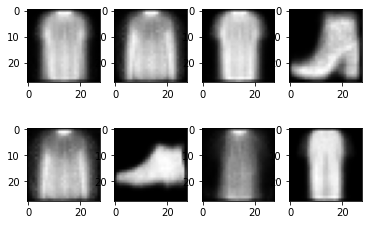

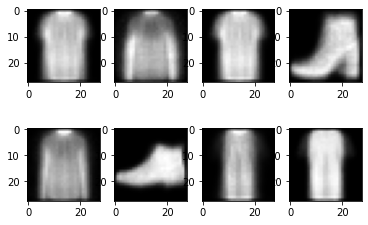

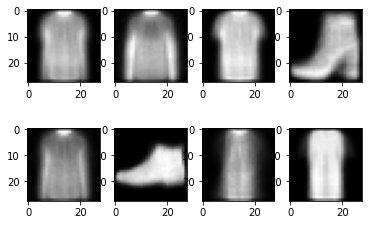

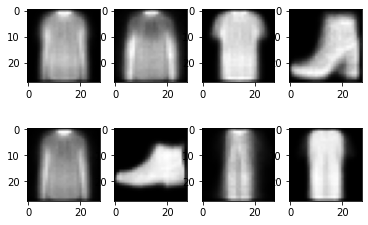

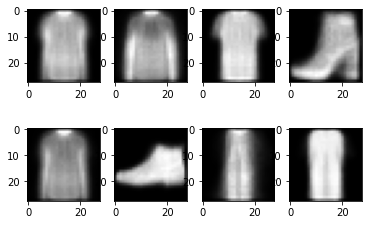

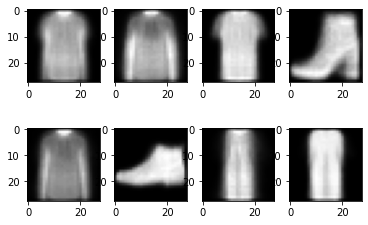

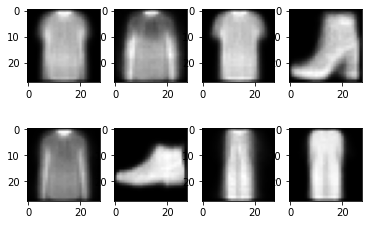

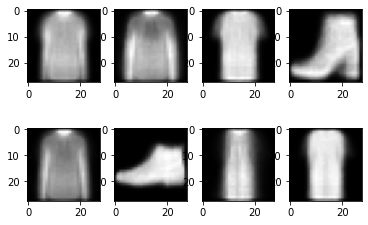

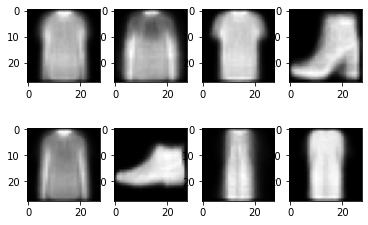

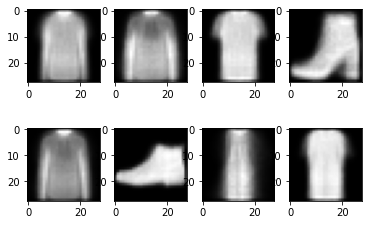

In [5]:
import matplotlib.gridspec as gridspec    
import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

# Sampling function (using the reparameterisation trick)
def sample(mu, log_sigma2):
    eps = torch.randn(mu.shape[0], mu.shape[1])#Returns a 2d tensor filled with random numbers from a standard normal distribution
    return mu + torch.exp(log_sigma2 / 2) * eps
    #log_sigma2 is log(sigma^2) and sampling is done via  mu + sigma * eps. Therefore you need to turn log_sigma2 into sigma.


#parameters
batch_size = 256
embedding_dim = 2
enc_hidden_units = 512
dec_hidden_units = 512

image_dim = 28*28

nEpoch = 10

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_hidden_units, embedding_dim)
dec = Decoder(embedding_dim, dec_hidden_units, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(train_loader, 0):
        inputs, _ = data

        optimizer.zero_grad()

        mu, log_sigma2 = enc(inputs)
        z = sample(mu, log_sigma2)
        outputs = dec(z)

        # E[log P(X|z)] - as images are binary it makes most sense to use binary cross entropy
        # we need to be a little careful - by default torch averages over every observation 
        # (e.g. each  pixel in each image of each batch), whereas we want the average over entire
        # images instead
        recon = F.binary_cross_entropy(outputs, inputs, size_average=False) / inputs.shape[0]
        
        kl = 0 
        # kl = D_KL(Q(z|X) || P(z|X)) - calculate in closed form
        # https://stats.stackexchange.com/questions/394296/how-should-i-intuitively-understand-the-kl-divergence-loss-in-variational-autoen
        # https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Basic_example
        # Compute the term kl which is then added to the total loss
        # YOUR CODE HERE
        # raise NotImplementedError()

        # https://pytorch.org/docs/stable/nn.functional.html
        # kl=F.kl_div(outputs,inputs)
        
        kl = torch.mean(torch.exp(log_sigma2) + mu**2 - 1 - log_sigma2)
        # By taking the torch.mean instead of the torch.sum(e.g. equation in https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/) can 
        # effectively normalize by the batch size(You need to divide KL by the batch size since you do the same for the recons loss)
        
        loss = recon + kl
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)

    
    ## Please display some of the generated images in the submitted Notebook
    # YOUR CODE HERE
    # raise NotImplementedError()
    enc.eval()
    dec.eval()
    
    for i in range(8):
      
      alex = outputs[i].data.reshape(28,28)
      plt.subplot(int(str(24)+str(i+1)))
      plt.imshow(alex, cmap=plt.get_cmap('gray'))

    plt.show()